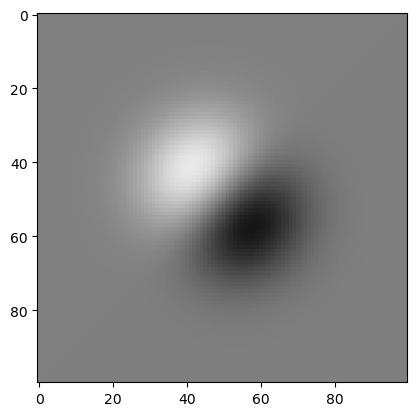

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

WAVELET_SIZE_PIX = 100
WAVELET_BOUNDS   = 3
NAKA_RUSHTON_SEMISAT  = 0.25
NAKA_RUSHTON_EXPONENT = 2.0
NAKA_RUSHTON_BACKGROUND_RATE = 1
NAKA_RUSHTON_MAX_SPIKE_RATE  = 20
NUM_SIMS_STOCHASTIC = 100

def steerable_filter(input_angle):

    dims = [-WAVELET_BOUNDS,WAVELET_BOUNDS,WAVELET_SIZE_PIX]
    x = np.linspace(dims[0], dims[1], dims[2])
    y = np.linspace(dims[0], dims[1], dims[2])
    X, Y = np.meshgrid(x, y)
    Gi = np.exp(-(X**2 + Y**2))
    GiPrimex = -2 * X * Gi
    GiPrimey = -2 * Y * Gi

    output = np.cos(input_angle)*GiPrimex + np.sin(input_angle)*GiPrimey
    return output / np.std(output.flat)

# test steerable filter wavelet
testWaveletAngle = 45
imWavelet = steerable_filter(np.deg2rad(testWaveletAngle))
plt.imshow(imWavelet, vmin=-5,vmax=5,cmap='gray')
plt.show()

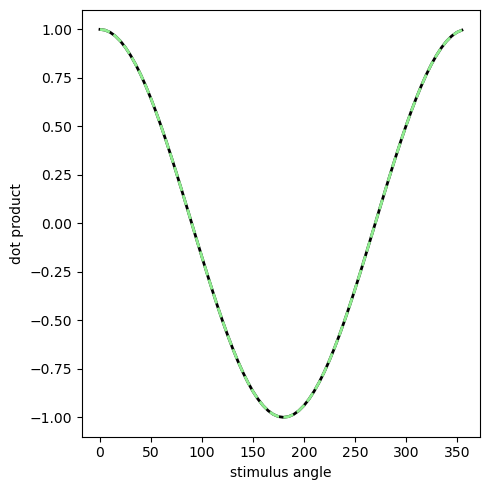

In [2]:
# test response that neuron with wavelet RF has to wavelet stimuli of other angles
rfAngles   = np.arange(0,360,90)
rfAngles   = [0]
stimAngles = np.arange(0,360,5)

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
ax = axes
for iRF, rfAngle in enumerate(rfAngles):
    imNeuronRF = steerable_filter(np.deg2rad(rfAngle))
    x = []
    y = []
    for iStim, stimAngle in enumerate(stimAngles):
        imStim = steerable_filter(np.deg2rad(stimAngle))
        dotProduct = np.dot(imNeuronRF.flat, imStim.flat) / len(imNeuronRF.flat)
        x.append(stimAngle)
        y.append(dotProduct)

    ax.plot(x,y,lw=2,color='black')
    ax.plot(stimAngles,np.cos(np.deg2rad(rfAngle-stimAngles)),ls='--',lw=2,color='lightgreen')

ax.set_xlabel('stimulus angle')
ax.set_ylabel('dot product')
plt.tight_layout()
plt.show()

## Math
We define a steerable wavelet function $W(\theta)$ which is used both for the wavelets in the stimulus *and* as the receptive field of neurons placed at each location. We imagine a grid of wavelets forming a stimulus, where the orientations of those wavelets are used to perform a task, and a matching grid of receptive fields tuned to a range of orientations that perfectly overlay that grid.

The "response" of a neuron with some oriented receptive field to a wavelet stimulus of contrast $c$ is calculated:

$r = W(\theta_{RF}) \cdot c W(\theta_{stim})$

and, thanks to the design of the steerable wavelet,

$r = W(\theta_{RF}) \cdot c W(\theta_{stim}) = c\times\cos(\theta_{RF} - \theta_{stim})$

we can convert this into an expected firing rate with the Naka-Rushton function

$\lambda(r) = \begin{cases} \lambda_0 + \lambda_{max} \times \frac{r^m}{r^m+r_{semisat}^m} & \text{if } r > 0,\\
\lambda_0 & \text{if } r \leq 0 \end{cases}$

or, equivalently for this case (because we have a single cycle of a cosine function),

$\theta_{\Delta} = \theta_{RF} - \theta_{stim}$

$\lambda(\theta_{\Delta},c) = \begin{cases} \lambda_0 + \lambda_{max} \times \frac{c^m\times \cos(\theta_{\Delta})^m}{c^m \times \cos(\theta_{\Delta})^m+r_{semisat}^m} & \text{if } |\theta_{\Delta}| < \pi/2,\\
\lambda_0 & \text{if } |\theta_{\Delta}| \geq \pi/2 \end{cases}$

if we assume a Naka-Rushton exponent of $m=2$, that may make things a bit easier as

$\cos(\theta_{\Delta})^2 = \frac{1}{2}\left[ 1+cos(2\theta_{\Delta})\right]$

$\lambda(\theta_{\Delta},c) = \begin{cases} \lambda_0 + \lambda_{max} \times \frac{c^2\times \frac{1}{2}\left[ 1+cos(2\theta_{\Delta})\right]}{c^2 \times \frac{1}{2}\left[ 1+cos(2\theta_{\Delta})\right]+r_{semisat}^2} & \text{if } |\theta_{\Delta}| < \pi/2,\\
\lambda_0 & \text{if } |\theta_{\Delta}| \geq \pi/2 \end{cases}$


$\lambda(\theta_{\Delta},c) = \begin{cases} \lambda_0 + \lambda_{max} \times \frac{1+cos(2\theta_{\Delta})}{1+cos(2\theta_{\Delta})+2(r_{semisat}/c)^2} & \text{if } |\theta_{\Delta}| < \pi/2,\\
\lambda_0 & \text{if } |\theta_{\Delta}| \geq \pi/2 \end{cases}$

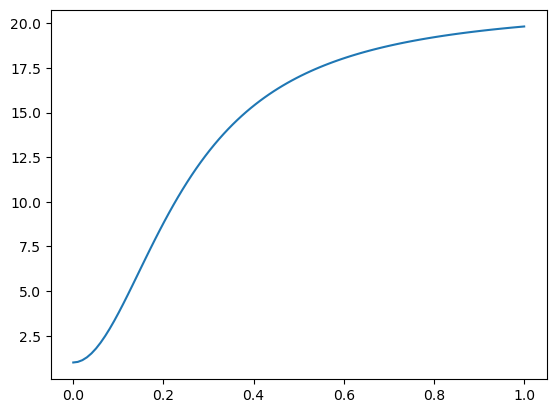

In [3]:
# Naka Rushton function for expected spike rate vs similarity
def simple_naka_rushton(x, semisat, exponent):
    x[x<0] = 0
    return NAKA_RUSHTON_BACKGROUND_RATE + NAKA_RUSHTON_MAX_SPIKE_RATE * x**exponent / (x**exponent + semisat**exponent)

x = np.linspace(0,1,100)
y = simple_naka_rushton(x, NAKA_RUSHTON_SEMISAT, NAKA_RUSHTON_EXPONENT)
plt.plot(x,y)
plt.show()

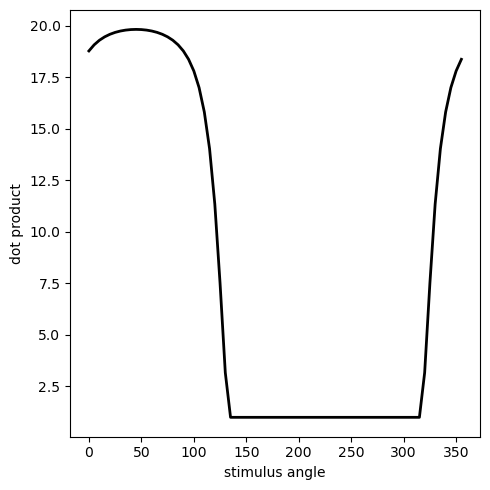

In [4]:
# test response that neuron with wavelet RF has to wavelet stimuli of other angles
rfAngles   = np.arange(0,360,90)
rfAngles   = [45]
stimAngles = np.arange(0,360,5)

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
ax = axes
for iRF, rfAngle in enumerate(rfAngles):
    imNeuronRF = steerable_filter(np.deg2rad(rfAngle))
    x = []
    y = []
    for iStim, stimAngle in enumerate(stimAngles):
        imStim = steerable_filter(np.deg2rad(stimAngle))
        dotProduct = np.dot(imNeuronRF.flat, imStim.flat) / len(imNeuronRF.flat)
        x.append(stimAngle)
        y.append(dotProduct)

    y2 = simple_naka_rushton(np.array(y), NAKA_RUSHTON_SEMISAT, NAKA_RUSHTON_EXPONENT)
    ax.plot(x,y2,lw=2,color='black')

ax.set_xlabel('stimulus angle')
ax.set_ylabel('dot product')
plt.tight_layout()
plt.show()

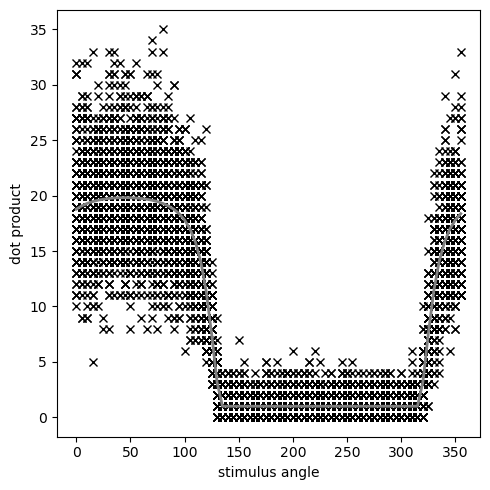

In [5]:
# stochastic model of firing rates
rfAngles   = np.arange(0,360,90)
rfAngles   = [45]
stimAngles = np.arange(0,360,5)

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
ax = axes
for iRF, rfAngle in enumerate(rfAngles):
    imNeuronRF = steerable_filter(np.deg2rad(rfAngle))
    x = []
    y = []
    for iStim, stimAngle in enumerate(stimAngles):
        imStim = steerable_filter(np.deg2rad(stimAngle))
        dotProduct = np.dot(imNeuronRF.flat, imStim.flat) / len(imNeuronRF.flat)
        x.append(stimAngle)
        thisLambda = simple_naka_rushton(np.array(dotProduct), NAKA_RUSHTON_SEMISAT, NAKA_RUSHTON_EXPONENT)
        y.append(thisLambda)

        for iSim in range(0,NUM_SIMS_STOCHASTIC):
            spikeRate = np.random.poisson(thisLambda)
            ax.plot(stimAngle,spikeRate,marker='x',color='black')
            
    ax.plot(x,y,lw=2,color='gray')

ax.set_xlabel('stimulus angle')
ax.set_ylabel('dot product')
plt.tight_layout()
plt.show()

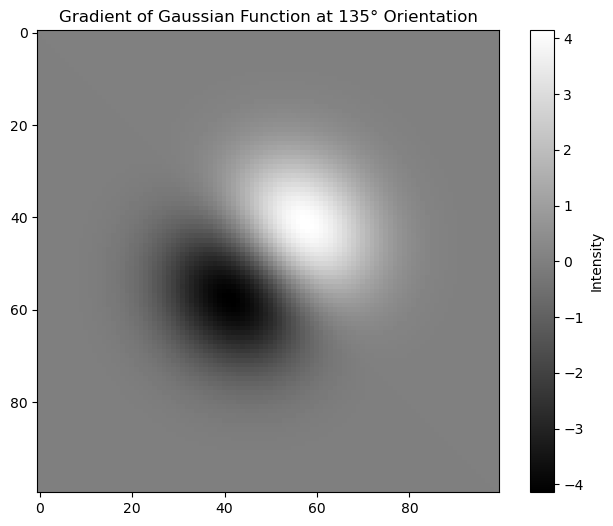

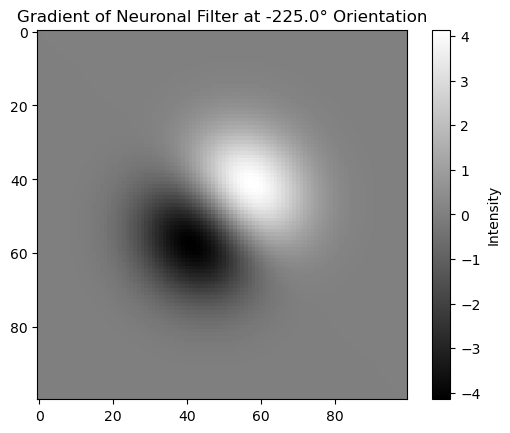

NameError: name 'matrix_dot_normal' is not defined

In [6]:
math_angle = 135
perp_math_angle = math_angle + 90 
perceived_angle = -math_angle + 90
prefered_angle = np.deg2rad(-225)
theta = np.deg2rad(math_angle)
GiPrimeTheta = steerable_filter(theta)
neuronFilter = steerable_filter(prefered_angle)
plt.figure(figsize=(8, 6))
# Get the maximum absolute value for symmetric color scaling
vmax = np.max(np.abs(GiPrimeTheta))
plt.imshow(GiPrimeTheta, cmap='grey', vmin=-vmax, vmax=vmax)
plt.title(f'Gradient of Gaussian Function at {math_angle}° Orientation')
plt.colorbar(label='Intensity')
plt.show()

plt.imshow(neuronFilter, cmap='grey', vmin=-vmax, vmax=vmax)
plt.title(f'Gradient of Neuronal Filter at {np.rad2deg(prefered_angle)}° Orientation')
plt.colorbar(label='Intensity')
plt.show()



dot_product = matrix_dot_normal(GiPrimeTheta,neuronFilter)
print(dot_product.shape())

"""
The next step is to convert this dot product to a neural firing rate.
The time frame in which the firing rate is arbitrary so lets just call it 1 second
The maximal firing rate is also a bit arbitrary 
but for physiological realism lets just call it like 20
and we want when the dot product is 1, that lambda = 20
and when the dot product is 0 we don't want much firing so we'll say that lambda has a minimum of 1
to keep things interesting
"""
lam = 19*matrix_dot_normal(GiPrimeTheta,neuronFilter)+1
print(matrix_dot_normal(GiPrimeTheta,neuronFilter))
print("spike count in time bin:",np.random.poisson(lam))

In [ ]:
def matrix_dot_normal(matrix1, matrix2):
    """
    Calculate similarity between two matrices as a proportion (0-1).
    
    Parameters:
    matrix1, matrix2: numpy arrays of the same shape
    
    Returns:
    float: Similarity proportion (0-1) where 1 means identical
    """
    # Flatten matrices
    flat1 = matrix1.flatten()
    flat2 = matrix2.flatten()
    
    # Calculate cosine similarity
    dot_product = np.dot(flat1, flat2)
    # Calculate norms
    norm1 = np.linalg.norm(flat1)
    norm2 = np.linalg.norm(flat2)

    # Avoid division by zero
    if norm1 == 0 or norm2 == 0:
        return 0.0
        
    similarity = dot_product / (norm1 * norm2)
    
    return similarity
matrix_dot_normal(GiPrimeTheta,neuronFilter)

In [ ]:
"""
The next step is to convert this dot product to a neural firing rate.
The time frame in which the firing rate is arbitrary so lets just call it 1 second
The maximal firing rate is also a bit arbitrary 
but for physiological realism lets just call it like 20
and we want when the dot product is 1, that lambda = 20
and when the dot product is 0 we don't want much firing so we'll say that lambda has a minimum of 1
to keep things interesting
"""
lam = 19*matrix_dot_normal(GiPrimeTheta,neuronFilter)+1
print("spike count in time bin:",np.random.poisson(lam))


In [ ]:
""" 
Now we want a 3x3 matrix of steerable wavelets and 4 neurons per wavelet, which have receptor 
fields for each target orientation (-225, -45, 45, 225)
Additionally we will need the coherence vs the mean variance versions
lets pick the coherence wavelets randomly, and we can pick the percent coherence randomly
for the time being
"""
coherence_orientation = np.random.choice([-45,45],1)
print(coherence_orientation)
#First Need angles of the 9 steerable wavelets
num_coherent = np.random.randint(0, 10)  # Random integer between 0 and 9
print("Number of coherent wavelets:", num_coherent)

# Calculate percentage of coherence
percent_coherence = num_coherent / 9
print("Percent coherence:", percent_coherence)

# Generate all wavelet indices (0 to 8)
all_wavelet_indices = np.arange(9)

# Randomly choose which wavelets are coherent
if num_coherent > 0:
	coherent_wavelet_indices = np.random.choice(all_wavelet_indices, num_coherent, replace=False)
	print("Coherent wavelet indices:", coherent_wavelet_indices)
else:
	coherent_wavelet_indices = np.array([])
	print("No coherent wavelets")

#I don't think that the position matters for how the computation is going to be done
#but it could be implemented in the future


In [ ]:
""" 
Neuron Filters -225 -45 45 225
"""
preferred_angles = [-225,-45,45,225]

neuron_filters = np.zeros((4,100,100))
angle_counter = 0
for i in range(4):
        neuron_filters[i] = (steerable_filter(np.deg2rad(preferred_angles[angle_counter])))
        angle_counter += 1
print(neuron_filters.shape)


In [ ]:
""" 
Stim filters
"""
random_angles = np.random.normal(0,90,9)
print(random_angles)
stimulus_filters = np.zeros((9,100,100))
angle_counter = 0
for i in range(9):
        current_index = angle_counter
        if current_index in coherent_wavelet_indices:
            angle = coherence_orientation[0]
        else:
            angle = random_angles[current_index]
            
        stimulus_filters[i] = (steerable_filter(np.deg2rad(angle)))
        angle_counter += 1
print(stimulus_filters.shape)


In [ ]:
neuron_population_dotprod_vector_array = np.zeros((4,9))
for j in range(9):
    for i in range(4):
        neuron_population_dotprod_vector_array[i,j] = matrix_dot_normal(neuron_filters[i],stimulus_filters[j])
        if neuron_population_dotprod_vector_array[i,j] < 0:
            neuron_population_dotprod_vector_array[i,j] = 0

print('Dot Product matrix:',neuron_population_dotprod_vector_array)
lam = np.zeros((9,4))
lam = 19*neuron_population_dotprod_vector_array+1
print("lambda Matrix:",lam)

neuron_population_firing_vector_array = np.zeros((4,9))

for i in range(4):
    neuron_population_firing_vector_array[i] = np.random.poisson(lam[i])

print('Firing rate Matrix:', neuron_population_firing_vector_array)

In [ ]:
vector_sum = np.zeros((4))
for i in range(9):
    vector_sum += neuron_population_firing_vector_array[:,i]
print(vector_sum)